# PHYS510: McDonalds store locations
### By Philippe Nguyen

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
import matplotlib.patches as patches

# Import data and look at  it

In [2]:
with open('mcD.txt') as f:
    reader = csv.reader(f, delimiter='\t')
    d = list(reader)
ll_full = pd.DataFrame(d, columns=['long', 'lat'])

# Convert str to float
for index, row in ll_full.iterrows():
    ll_full.loc[index,'long'] = float(row[0])
    ll_full.loc[index,'lat'] = float(row[1])

### Let's literally look at it first...

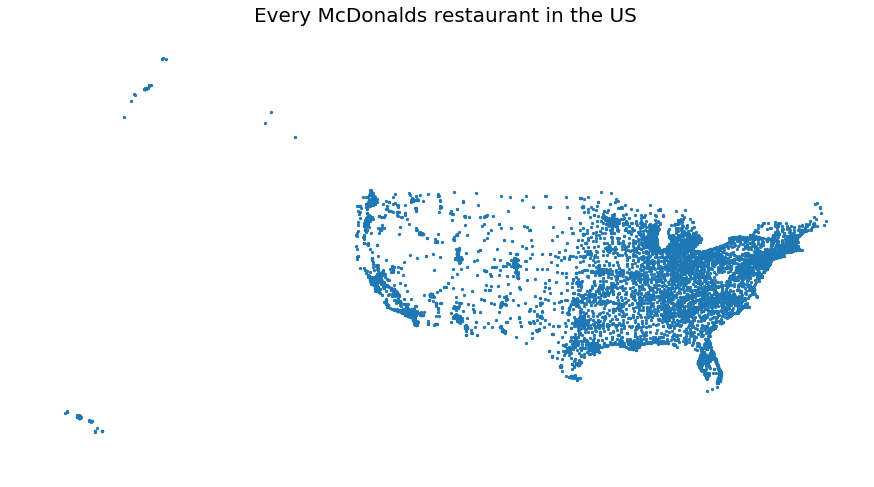

In [3]:
plt.figure(figsize=(15,8))
plt.scatter(ll_full['long'], ll_full['lat'], s=5)
plt.title('Every McDonalds restaurant in the US', size=20)
plt.axis('equal')
plt.axis('off')
plt.show()

Alaskans aren't big on Mickey D's... Hey look, there are are lot of restaurants along I-5, I-15, I-80, and I-84! There are a few others as well, but not as obvious. The western interstates are probably more apparent due to the Rocky Mountains limiting restaurant placement. It's worth noting that the obvious inference to make is that the density correlates with population, based on the apparent clustering near crowded cities. However, the filaments along these highways is more indicitave of *accessibility* rather than population. Having restaurants where people can reach them is probably a good way to expand your consumer base beyond just crowded cities.

In [4]:
print('Number of restaurants:', ll_full.count()[0])

Number of restaurants: 14170


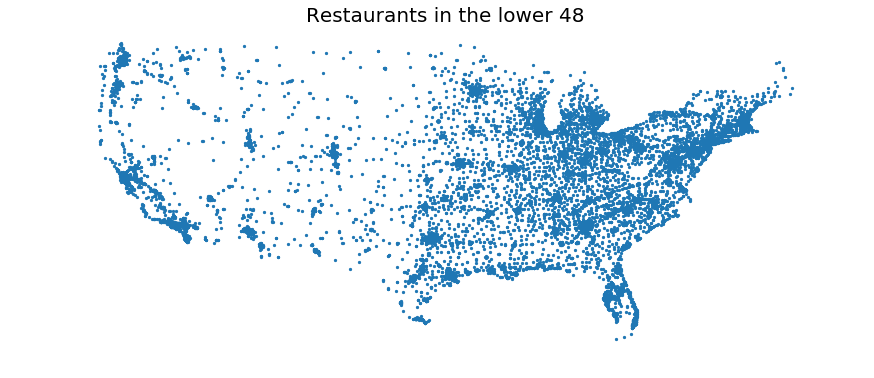

In [5]:
# Let's get rid of Alaska and Hawaii by omitting points with long < -124.44,
# the westernmost point of the west coast.
ll_lower_states = ll_full[ll_full['long'] > -124.44]

# Plot it to make sure!
plt.figure(figsize=(15,6))
plt.scatter(ll_lower_states['long'], ll_lower_states['lat'], s=5)
plt.title('Restaurants in the lower 48', size=20)
plt.axis('equal')
plt.axis('off')
plt.show()

In [6]:
def heat_map(x,y,xbin=50,ybin=50):
    """Give me x and y positions, and a number of bins for each dim, and I spit out a density array for those bins."""
    x_arr=np.array(x)
    y_arr=np.array(y)
    
    # Create bins and empty density array
    x_bins = np.linspace(min(x_arr),max(x_arr),xbin)
    y_bins = np.linspace(min(y_arr),max(y_arr),ybin)
    density = np.zeros((len(x_bins), len(y_bins)))

    # Loop over bins in both dimensions
    for i in range(len(x_bins)-1):
        for j in range(len(y_bins)-1):
            # Bin edges
            x_low = x_bins[i]
            x_high = x_bins[i+1]
            y_low = y_bins[j]
            y_high = y_bins[j+1]
            # Count x,y data that fall between bin edges
            where_index = np.where((x_arr >= x_low) & (x_arr <= x_high) & (y_arr >= y_low) & (y_arr <= y_high))[0]
            density[i,j] = len(where_index)
            x_arr = np.delete(x_arr, where_index)
            y_arr = np.delete(y_arr, where_index)
    
    density = np.transpose(density)
    
    # Return density array and x,y bin arrays
    return density, x_bins, y_bins

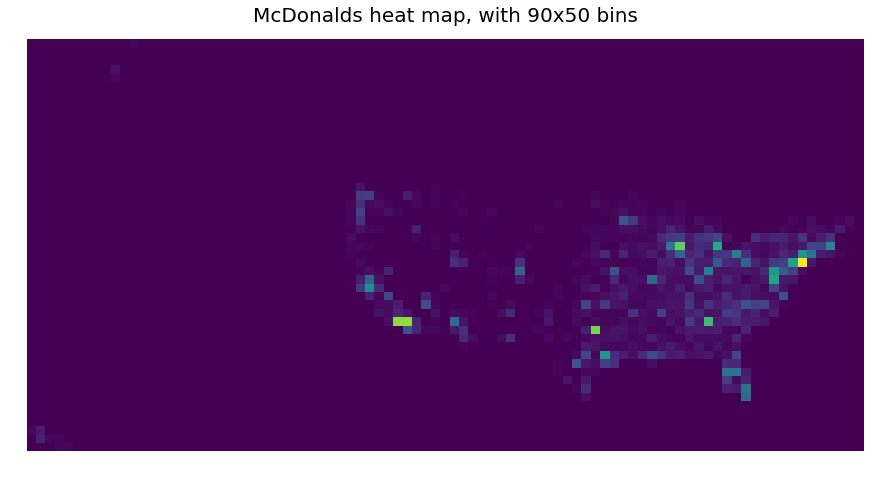

In [7]:
# Create heat map for FULL data set. This can take a few seconds depending on bin numbers!
long_full = ll_full['long']
lat_full = ll_full['lat']
density_full, long_full_bins, lat_full_bins = heat_map(long_full, lat_full, 90, 50)

# Heat map plot
plt.figure(figsize=(15,8))
plt.pcolor(long_full_bins, lat_full_bins, density_full)
plt.title('McDonalds heat map, with {}x{} bins'.format(len(long_full_bins),len(lat_full_bins)) , size=20)
plt.axis('equal')
plt.axis('off')
plt.show()

There are a few hotspots noticeable: LA, Chicago, Dallas, Atlanta, NY...

If we want to look at any particular region, we're gonna need some function that will find points inside a path.

In [8]:
def inside_path(coords, verts):
    """Gimme the vertices of a path and I'll use mpl.Path to return coords that are inside the path"""
    """Coords must be list or array of coordinate pair tuples!!"""
    
    # Make sure vertices form a full path
    if verts[-1] != verts[0]:
        verts.append(verts[0])
    
    # Make path codes
    codes = [mplPath.Path.MOVETO]
    for i in range(len(verts)-1):
        codes.append(mplPath.Path.LINETO)
        
    # Create Path object
    my_path = mplPath.Path(verts, codes)
    
    inside = []
    for x in coords:
        if my_path.contains_point(x):
            inside.append(x)
    
    return inside, my_path

### McDeezy distribution: California vs Georgia

Let's use this function and the `heat_map` function before to see the distributions in California and Georgia. Here I've used Google maps to approximately define some vertices for each state. They include some ocean space, but that doesn't matter if there aren't any restaurants out there!

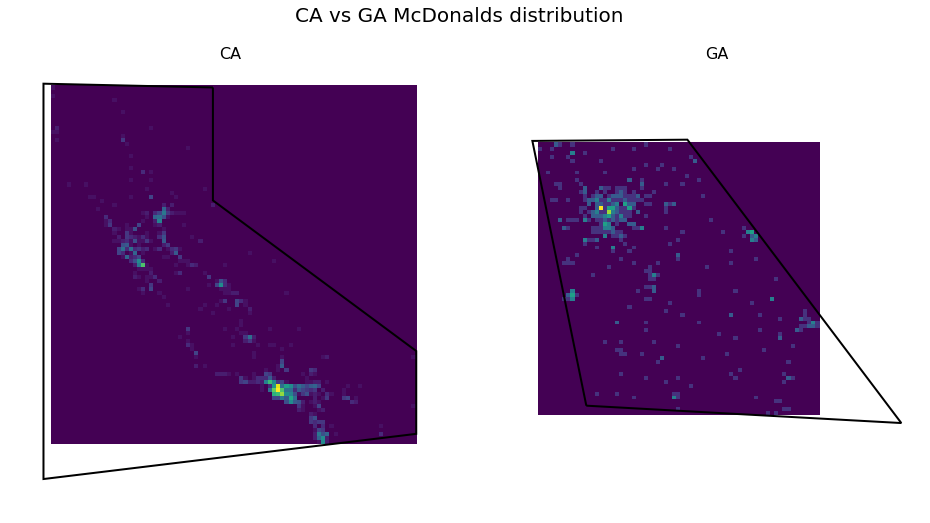

In [9]:
# I want coord pairs to plug into inside_path function
coords_full = [tuple(x) for i, x in ll_full.iterrows()]

vertices_ca = [(-120.0,42.0),
            (-120.0,39.0),
            (-114.6,35.0),
            (-114.6,32.8),
            (-124.5,31.6),
            (-124.5,42.1)]
vertices_ga = [(-84.74,30.71),
            (-85.61,34.98),
            (-83.11,35.00),
            (-79.66,30.43)]

# Create paths and find data inside thos paths
ll_ca, ca_path = inside_path(coords_full, vertices_ca)
ll_ga, ga_path = inside_path(coords_full, vertices_ga)

long_ca, lat_ca = [[x[i] for x in ll_ca] for i in range(2)]
long_ga, lat_ga = [[x[i] for x in ll_ga] for i in range(2)]

# Create heat map data
density_ca, xbins_ca, ybins_ca = heat_map(long_ca, lat_ca, 90, 90)
density_ga, xbins_ga, ybins_ga = heat_map(long_ga, lat_ga, 70, 70)


# Plot the two distributions as well as their "borders"
fig = plt.figure(figsize=(16,8))
fig.suptitle('CA vs GA McDonalds distribution', size=20)

ax = fig.add_subplot(1,2,1)
ax.pcolor(xbins_ca, ybins_ca, density_ca)
patch = patches.PathPatch(ca_path, facecolor='none', lw=2)
ax.add_patch(patch)
plt.title('CA', size=16)
plt.axis('equal')
plt.axis('off')

ax = fig.add_subplot(1,2,2)
ax.pcolor(xbins_ga, ybins_ga, density_ga)
patch = patches.PathPatch(ga_path, facecolor='none', lw=2)
ax.add_patch(patch)
plt.title('GA', size=16)
plt.axis('equal')
plt.axis('off')

plt.show()

Very different distributions. In California, we see some crazy clustering around the Los Angeles and Orange County area in the south, and the bay area and Sacramento to the north. In Georgia, it looks much like a single cluster at Atlanta and some outliers around the state.

# Clustering, first pass

Let's look at an arbitrary rectangular sample area which goes in latitude from 38.9 (South) to 41.8 (North) and in longitude from -86.4 (West) to -81.9 (East). We'll use the same `inside_path` function to get all the data inside the region first, and convert the long-lat coordinates to km while we're at it (with the bottom-left-most point being 0 km x 0 km).

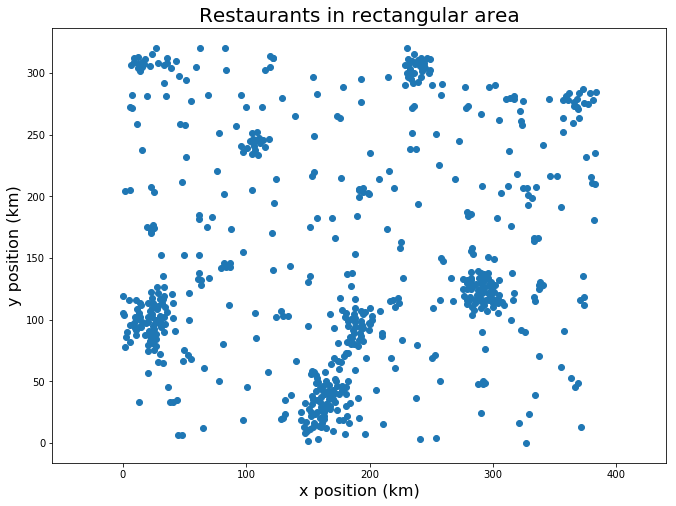

In [10]:
vertices_rect = [(-86.4,38.9),
            (-86.4,41.8),
            (-81.9,41.8),
            (-81.9,38.9)]
ll_rect, rect_path = inside_path(coords_full, vertices_rect)
long_rect, lat_rect = [[x[i] for x in ll_rect] for i in range(2)]

# Conversion of degrees to km from Prime Meridian (longitude) and Equator (latitude)
long_rect = np.asarray(long_rect)
lat_rect = np.asarray(lat_rect)
long_rect_km = 111.320*np.cos(np.median(lat_rect)*np.pi/180.)*long_rect # km west of Prime Meridian
long_rect_km -= min(long_rect_km)
lat_rect_km = 110.574*lat_rect #km north of equator
lat_rect_km -= min(lat_rect_km)

coords_rect = [(long_rect_km[i], lat_rect_km[i]) for i in range(len(long_rect_km))]

# What's in the box?!
plt.figure(figsize=(11,8))
plt.scatter(long_rect_km, lat_rect_km)
plt.title('Restaurants in rectangular area', size=20)
plt.axis('equal')
plt.xlabel('x position (km)',size=16)
plt.ylabel('y position (km)',size=16)
# plt.axis('off')
plt.show()

There is plenty of clustering here. I see roughly seven clusters, two of which could be considered a larger-scale cluster than the others. There are also several small-scale (a few points) clusters between the larger clusters.

Now let's try heat-mapping at different bin sizes and see if we learn anything!

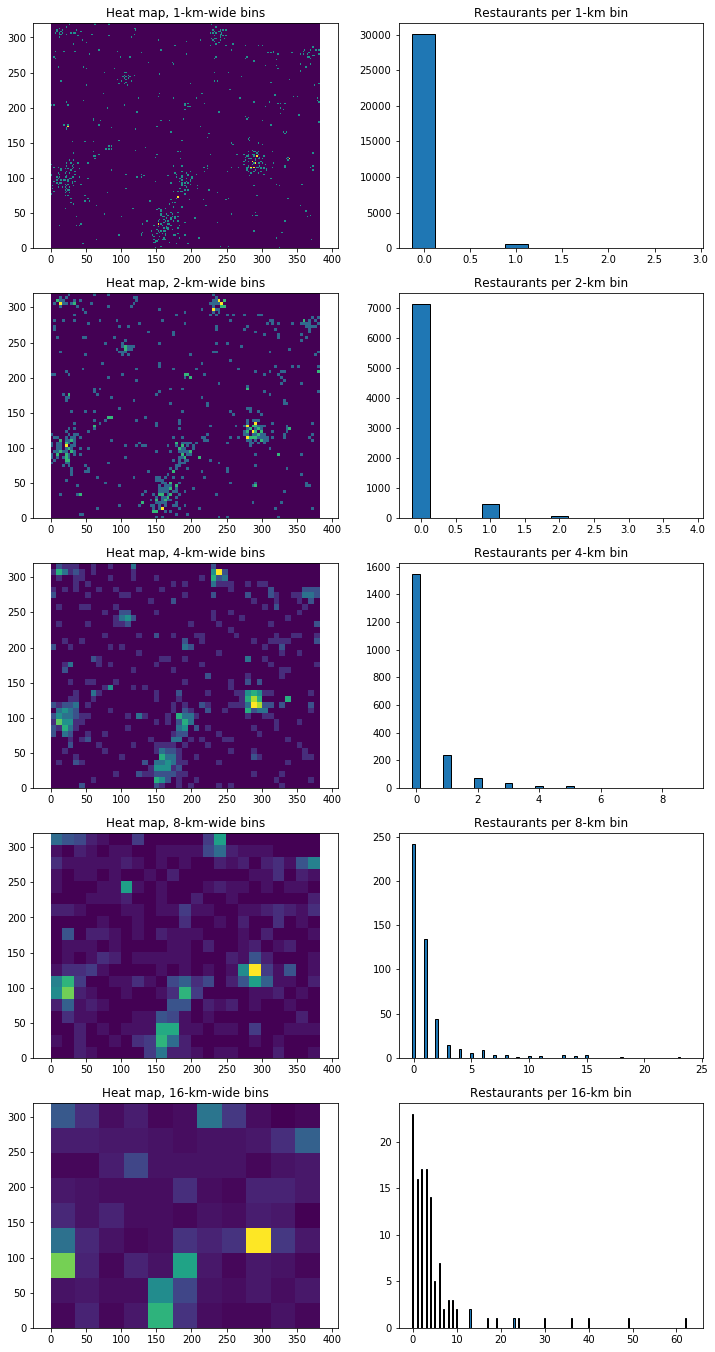

In [11]:
# Make a bunch of plots... one for each box size: 1, 2, 4, 8, and 16 km box widths

# x & y dimensions of rectangular area
delta_long_km = max(long_rect_km)
delta_lat_km = max(lat_rect_km)

fig = plt.figure(figsize=(12,24))

for i in range(5):
    long_rect_km_bin_count = int(round(delta_long_km/(2**(i+1))))
    lat_rect_km_bin_count = int(round(delta_lat_km/(2**(i+1))))

    density_rect_km, long_rect_km_bins, lat_rect_km_bins = heat_map(long_rect_km, lat_rect_km, 
                                                                 long_rect_km_bin_count, lat_rect_km_bin_count)

    fig.add_subplot(5,2,2*i+1)
    ax = plt.pcolor(long_rect_km_bins, lat_rect_km_bins, density_rect_km)
    plt.axis('equal')
    plt.title('Heat map, {}-km-wide bins'.format([1,2,4,8,16][i]))
    
    fig.add_subplot(5,2,2*i+2)
    hist_data = density_rect_km.flatten()
    plt.hist(hist_data, np.arange(min(hist_data), max(hist_data)+2, 1)-.125, edgecolor='k', width=0.25)
    plt.title('Restaurants per {}-km bin'.format([1,2,4,8,16][i]))

plt.show()

* The smallest bin size is over-resolving: we can't get that much info about clustering when nearly all the points have either one or zero restaurants. Sure, we can still see the clusters using our eyes, but it's hardly better than the original scatter plot if we're trying to develop a clustering algorithm.

* The 2-km bin size starts to reveal some contiguous shapes in the heat map, although the histogram suggests we are still getting very little dynamic range: it won't be easy to define a background if most of the bins have the same counts!

* At 4-km bin size, we see a useful development: some clusters are 'brighter' than others, and as the histogram suggests, there is a good chance we can distinguish between a background and foreground in the data.

* The 8-km data is showing a lot of background, but also a lot of signal above that background. Check out that histogram! We are starting to lose resolution, however, so 'dimmer' clusters are starting to fade into the background.

* With 16-km bins, we are losing resolution and no small clusters are identifiable. And that histogram isn't looking so great.

Now let's focus on the 8-km bin data, since we have a clearly discernable background and foreground. We'll need to determine that background (using Poisson statistics) and re-visualize the heat map according to over- and under-density data.

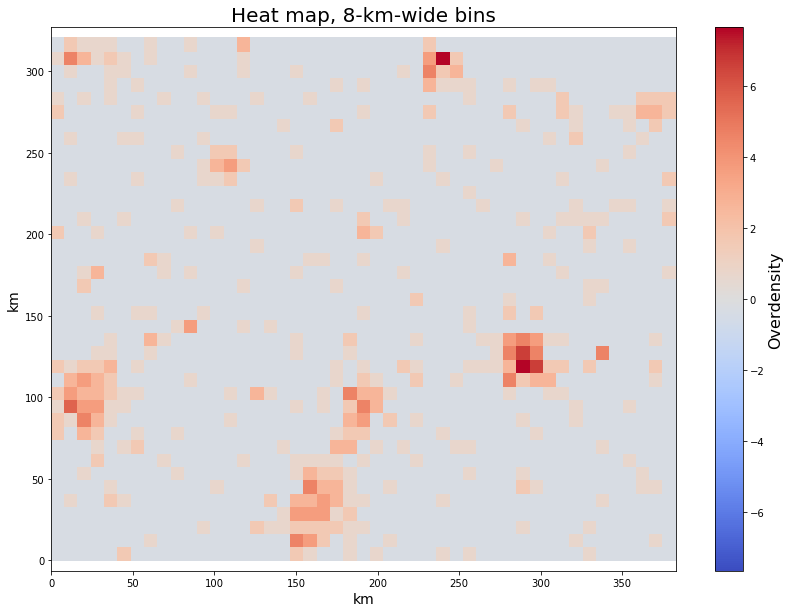

In [12]:
long_rect_bin_count = int(round(delta_long_km/8))
lat_rect_bin_count = int(round(delta_lat_km/8))

density_rect_8km, long_rect_bins_8km, lat_rect_bins_8km = heat_map(long_rect_km, lat_rect_km, 
                                                                   long_rect_bin_count, lat_rect_bin_count)

bg_rect_8km = np.mean(density_rect_8km)
overdensity_rect_8km = density_rect_8km - bg_rect_8km

# Plot new heat map
plt.close('all')
plt.figure(figsize=(14,10))
pcm = plt.pcolor(long_rect_bins_8km, lat_rect_bins_8km, overdensity_rect_8km, cmap='coolwarm')
pcm.set_clim(-np.max(overdensity_rect_8km),np.max(overdensity_rect_8km))
cbar = plt.colorbar(pcm)
cbar.ax.set_ylabel('Overdensity', size=16)
plt.axis('equal')
plt.title('Heat map, 8-km-wide bins', size=20)
plt.xlabel('km', size=14)
plt.ylabel('km', size=14)

plt.show()

### Counting in circles

Now let's use circles to determine densities. The previous `inside_path` function won't do, so we'll need to define a new function for finding points inside a circle.

In [13]:
def inside_circle(coords, center, rad):
    """
    Gimme a circle and I'll use mplt.circle to return coords that are inside it.
    Coords must be list or array of coordinate pair tuples!!
    Center must be a coordinate pair tuple.
    """
    
    # Create Path object
    my_path = mplPath.Path.circle(center, rad)
    
    inside = []
    for x in coords:
        if my_path.contains_point(x):
            inside.append(x)
    
    return inside, my_path

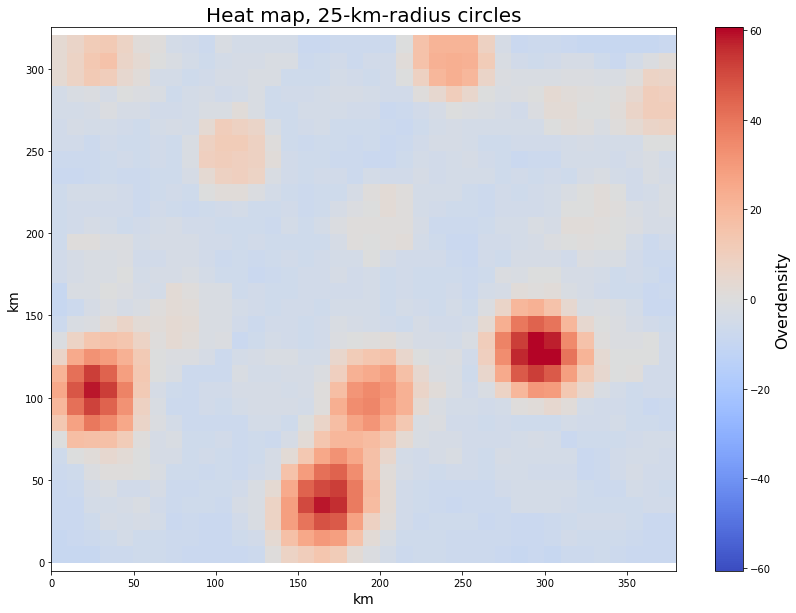

In [14]:
rad = 25. #km

x_grid = np.arange(0., max(long_rect_km), 10.)
y_grid = np.arange(0., max(lat_rect_km), 10.)

centers = [[(x, y) for x in x_grid] for y in y_grid]
density_rect_circle = np.zeros((len(y_grid), len(x_grid)))

for i in range(len(centers)):
    for j in range(len(centers[i])):
        c=centers[i][j]
        density_rect_circle[i,j] = len(inside_circle(coords_rect, c, rad)[0])

bg_rect_circle = np.mean(density_rect_circle)
overdensity_rect_circle = density_rect_circle-bg_rect_circle

# Plot overdensity
plt.close('all')
plt.figure(figsize=(14,10))
pcm = plt.pcolor(x_grid, y_grid, overdensity_rect_circle, cmap='coolwarm')
pcm.set_clim(-np.max(overdensity_rect_circle),np.max(overdensity_rect_circle))
cbar = plt.colorbar(pcm)
cbar.ax.set_ylabel('Overdensity', size=16)
plt.axis('equal')
plt.title('Heat map, 25-km-radius circles', size=20)
plt.xlabel('km', size=14)
plt.ylabel('km', size=14)
plt.show()

### Characteristic void size

We can implement the counting-in-circles procedure as a way of determining the characteristic void size as well. The following fuction starts with a some starting void size. It then slides the void around and counts how many times the void doesn't contain any data points. If this is more than zero, we increase the void radius by an amount '`dr`' and redo the search. If we find zero locations, we stop searching and the return the most recent void radius as the maximum void radius.

In [15]:
def void_max(coords, centers, srad, dr):
    """
    Determines the maximum circular void size of a distribution of points.
    Takes in coordinates of dataset and centers to try fitting voids into.
    Starting radius is given by 'srad', increments given by 'dr'.
    """
    
    void_rad_max = srad
    empty_count = 1
    while empty_count > 0:
        empty_count = 0
        for i in range(len(void_centers)):
            for j in range(len(void_centers[i])):
                n_in_void = inside_circle(coords_rect, void_centers[i][j], void_rad_max)[0]
                if len(n_in_void) == 0:
                    empty_count += 1
                    break
        void_rad_max += dr
    return void_rad_max - 2*dr

In [16]:
# Spots to try in void search
x_void_grid = np.arange(0., max(long_rect_km), 10.)
y_void_grid = np.arange(0., max(lat_rect_km), 10.)
void_centers = [[(x, y) for x in x_void_grid] for y in y_void_grid]

void_max_rect = void_max(coords_rect, void_centers, 40., 1.)
print('Maximum void size =', void_max_rect, 'km')

Maximum void size = 41.0 km


Unfortunately, this makes no sense. By inspection (with my eyes) this shouldn't be more than ~20-25 km.

# Clustering, second pass

Let's apply a nearest-neighbor approach to clustering the data. We'll need to create a function for finding the nearest neighbor and its distance, and one for finding the average NN distance in a sample.

In [17]:
def NN_distance(a, neighbors):
    """
    Takes a point 'a' and neighboring points, finds the nearest neighbor and its distance to 'a'.
    """
    
    NN_d = np.linalg.norm(a-np.array(neighbors[0]))
    NN = neighbors[0]
    for x in neighbors[1:]:
        d = np.linalg.norm(a-np.array(x))
        if d < NN_d:
            NN_d = d
            NN = x
    return NN_d, NN



def NN_avg_distance(coords):
    """
    Takes in list of coordinates, computes distance between each pair of elements, returns avg distance.
    """
    
    N = len(coords)
    x,y = [[c[j] for c in coords] for j in [0,1]]
    x_range = np.abs(max(x) - min(x))
    y_range = np.abs(max(y) - min(y))
    A = x_range * y_range
    expected = 0.5/np.sqrt(N/A)

    NN_d_list = []
    for i in range(len(coords)):
        a = coords[i]
        neighbors = np.delete(np.array(coords), i, axis=0)

        NN_d, NN = NN_distance(a, neighbors)
        NN_d_list.append(NN_d)

    NN_d_avg = np.mean(NN_d_list)
    ANN = NN_d_avg / expected

    return NN_d_avg, ANN, NN_d_list

Average Nearest-Neighbor distance in full sample area: 5.94487884638
Average Nearest-Neighbor ratio in full sample area: 0.855105691208


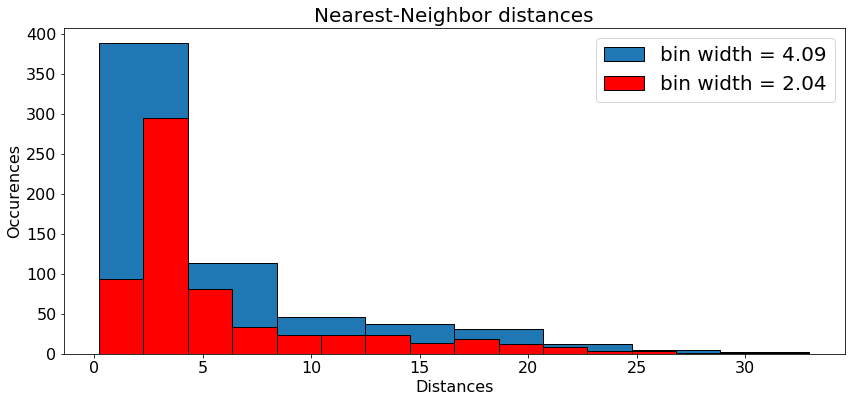

In [18]:
NN_d_avg_rect, ANN_rect, NN_d_list_rect = NN_avg_distance(coords_rect)
print('Average Nearest-Neighbor distance in full sample area:', NN_d_avg_rect)
print('Average Nearest-Neighbor ratio in full sample area:', ANN_rect)

plt.figure(figsize=(14,6))
nbins = 8
hist_range = max(NN_d_list_rect) - min(NN_d_list_rect)
h1, bins1, patches1 = plt.hist(NN_d_list_rect, edgecolor='k', bins=nbins, label='bin width = {:.2f}'.format(hist_range/nbins))
plt.hist(NN_d_list_rect, edgecolor='k', facecolor='r', bins=nbins*2, label='bin width = {:.2f}'.format(hist_range/(nbins*2)))
plt.xticks(size=16)
plt.yticks(size=16)
plt.title('Nearest-Neighbor distances', size=20)
plt.xlabel('Distances', size=16)
plt.ylabel('Occurences', size=16)
plt.legend(loc='upper right', fontsize=20)
plt.show()

The function we used before for finding points inside a box is a bit clunky for this next part. Let's make a simpler function for sampling small boxes.

In [19]:
def inside_box(coords, x_min, x_max, y_min, y_max):
    coords_inside_box = []
    for x in coords:
        if (x[0] > x_min) & (x[0] < x_max) & (x[1] > y_min) & (x[1] < y_max):
            coords_inside_box.append(x)
    return coords_inside_box

We'll now sample many boxed areas within our full rectangular sample by sliding a 100km x 100km box over the region in small (< 100km) steps, computing the mean nearest-neighbor distance per box location. Areas of where this metric is low should indicate a cluster. We can then use our full-sample mean `NN_d_avg_rect` as a threshold for differentiating between clusters and voids, and produce a solid map of clusters.

In [20]:
# Number of full boxes we want to fit into sample area
x_boxes = 20
y_boxes = 20

dx = (max([x[0] for x in coords_rect])-100.)/(x_boxes-1)
dy = (max([x[1] for x in coords_rect])-100.)/(y_boxes-1)

# Number of actual iterations, more than x,y_boxes in order to cover last bin
x_iter = x_boxes + int(100/dx)
y_iter = y_boxes + int(100/dy)

NN_d_avg_rect_boxes = np.zeros((y_iter, x_iter))
for i in range(y_iter):
    for j in range(x_iter):
        coords_rect_box = inside_box(coords_rect, 0.+(j*dx), 100.+(j*dx), 0.+(i*dy), 100.+(i*dy))
        if len(coords_rect_box) > 1:
            NN_d_avg_box, ANN_box, NN_d_list_box = NN_avg_distance(coords_rect_box)
            NN_d_avg_rect_boxes[-1-i,j] = NN_d_avg_box
        else:
            NN_d_avg_rect_boxes[-1-i,j] = void_max_rect

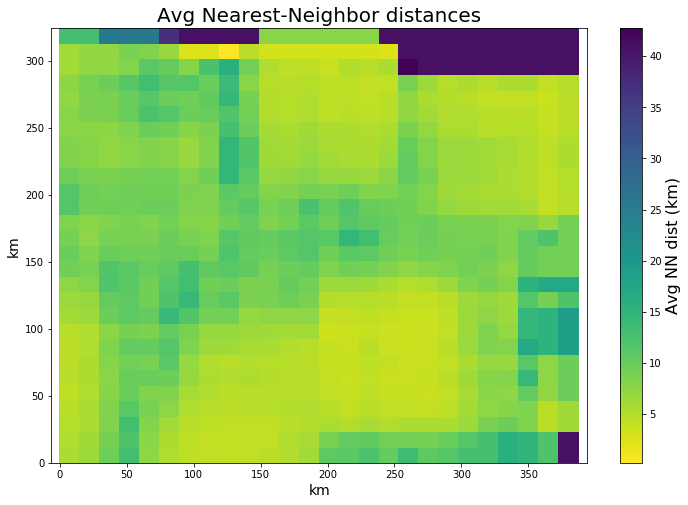

In [21]:
x = np.arange(0., x_boxes*dx + 100., dx)
y = np.arange(0., y_boxes*dy + 100., dy)

plt.close('all')
plt.figure(figsize=(12,8))
pcm = plt.pcolor(x,y,NN_d_avg_rect_boxes[::-1,:], cmap='viridis_r')
cbar = plt.colorbar(pcm)
cbar.ax.set_ylabel('Avg NN dist (km)', size=16)
plt.axis('equal')
# plt.axis('off')
plt.title('Avg Nearest-Neighbor distances', size=20)
plt.xlabel('km', size=14)
plt.ylabel('km', size=14)

plt.show()

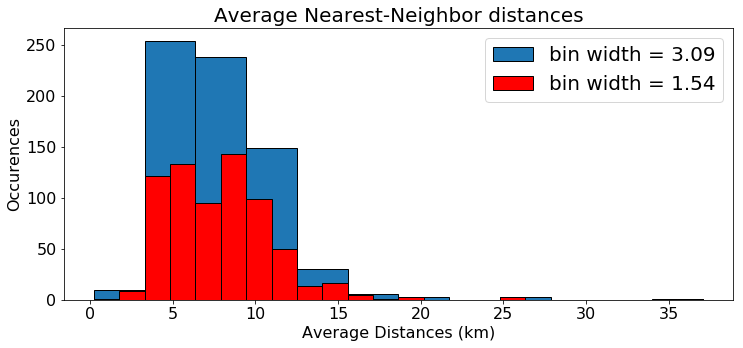

In [22]:
plt.figure(figsize=(12,5))
nbins = 12
hist_data = NN_d_avg_rect_boxes[NN_d_avg_rect_boxes < 40].flatten()
plt.hist(hist_data, edgecolor='k', bins=nbins, label='bin width = {:.2f}'.format(max(hist_data)/nbins))
plt.hist(hist_data, edgecolor='k', bins=nbins*2, facecolor='r', label='bin width = {:.2f}'.format(max(hist_data)/(2*nbins)))
plt.xticks(size=16)
plt.yticks(size=16)
plt.title('Average Nearest-Neighbor distances', size=20)
plt.xlabel('Average Distances (km)', size=16)
plt.ylabel('Occurences', size=16)
plt.legend(loc='upper right', fontsize=20)

plt.show()

### Comparison to total average:
The distribution is a lot less like a Poisson distribution when sampling over 100x100 km boxes. This suggests it's very likely restaurants in this regions are not randomly distributed. We want to now extract the clusters from the above heatmap by setting all bins lower than the total mean NN distance to 1, and all bins greater than the total mean NN distance to 0.

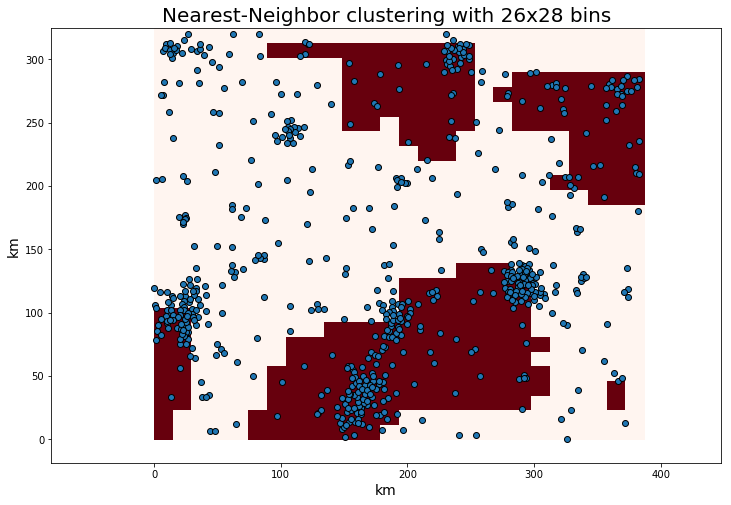

In [23]:
NN_d_avg_rect_clust = np.zeros((y_iter, x_iter))
for i in range(y_iter):
    for j in range(x_iter):
        if NN_d_avg_rect_boxes[-1-i,j] < NN_d_avg_rect:
            NN_d_avg_rect_clust[-1-i,j] = 1.

plt.figure(figsize=(12,8))
pcm = plt.pcolor(x, y, NN_d_avg_rect_clust[::-1,:], cmap='Reds')
plt.scatter(long_rect_km, lat_rect_km, edgecolor='k')
plt.axis('equal')
# plt.axis('off')
plt.title('Nearest-Neighbor clustering with {}x{} bins'.format(x_iter, y_iter), size=20)
plt.xlabel('km', size=14)
plt.ylabel('km', size=14)

plt.show()

Well this looks alright in some spots, but for the most part it's pretty garbage. But enough of this, let's try a clustering algorithm that deals with dense clusters a little better: the k-means method.

## K-Means clustering

Let's try a k-means clustering via Lloyd's algorithm. This is an iterative process with the following structure:
    1. Initialize the cluster centroids by randomly placing 'k' points in the sampling space. These are our centroids.
    2. Update clusters by labeling each data point with the centroid closest to it.
    3. For each cluster, find the mean position of the data points, and make this the new centroid.
    4. If a convergence requirement or time limit is satisfied, stop here. Otherwise, go back to step 2.

In [24]:
def update_clusters(coords, centroids):
    """Assign points to nearest centroids"""
    clusters = {'{}'.format(i): [] for i in range(len(centroids))}
    for x in coords:
        NC_d, NC = NN_distance(x, centroids) # Get nearest-centroid distance and nearest centroid
        NC_key = str(centroids.index(NC))
        clusters[NC_key].append(x)
    return clusters

def update_centroids(coords, clusters):
    """Find mean position of clusters and make those the new cluster centroids"""
    clusters_keys = list(clusters.keys())
    centroids_new = []
    for c in clusters_keys:
        mean_x = np.mean([x[0] for x in clusters[c]])
        mean_y = np.mean([x[1] for x in clusters[c]])
        centroids_new.append((mean_x, mean_y))
    return centroids_new

def k_means(coords, k, max_iter):
    """
    Run the k_means algorithm. Give me coordinates as a list of tuples, the number of clusters (k),
    and some limit of iterations max_iter. Have plot_results=True to plot the final clustering.
    """
    import random
    centroids_old = random.sample(coords, k)
    converge = False
    i = 0
    while converge == False:
        clusters = update_clusters(coords, centroids_old)
        centroids_new = update_centroids(coords, clusters)
        if centroids_old == centroids_new:
            converge = True
            print('Clustering with converged in {} iterations!'.format(i))
        elif i == max_iter:
            converge = True
            print('Could not converge; stopped at {} iterations!'.format(i))
        else:
            centroids_old = centroids_new
            i += 1
    
    # Determine background
#     bg_counts = np.mean(list({key: len(clusters[key]) for key in clusters.keys()}.values()))
    NN_d_all = [NN_avg_distance(clusters[key])[0] for key in clusters.keys()]
    bg_NN_d = np.mean(NN_d_all)+np.std(NN_d_all)
        
    return clusters, centroids_new

At a glance, I see around 7 clusters of various sizes, so let's see what we get with `k` = 7.

Clustering with converged in 7 iterations!


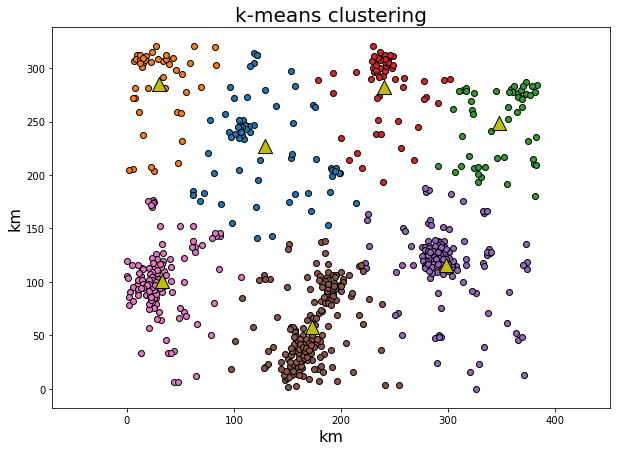

In [25]:
clusters_rect, centroids_rect = k_means(coords_rect, 7, 30)

plt.figure(figsize=(10,7))
for key in clusters_rect.keys():
    plt.scatter([j[0] for j in clusters_rect[key]], [j[1] for j in clusters_rect[key]], edgecolor='k')
plt.scatter([c[0] for c in centroids_rect], [c[1] for c in centroids_rect],
            edgecolor='k', facecolor='y', marker='^', s=200)
plt.axis('equal')
plt.title('k-means clustering', size=20)
plt.xlabel('km', size=16)
plt.ylabel('km', size=16)

plt.show()

Not bad! But we're running into a fundamental problem in k-means clustering: all points are clustered, including those that comprise the "background" of the dataset. Notice in particular the voids with centroids in them. What we could do is try to remove this background by determining the background event density via the "counting-in-circles" procedure used earlier and getting rid of data points that fall below the average event density, and perform k-means clustering on this reduced data set. This effectively clusters the data in two parts, first via count density and second via k-means.

In [26]:
def circle_overdensity(coords, x_arr, y_arr, rad):
    """
    Determine density distribution of data set using circle-counting, and from that
    get the over-density.
    """
    centers = [[(x, y) for x in x_arr] for y in y_arr]
    density_circle = np.zeros((len(y_arr), len(x_arr)))
    for i in range(len(centers)):
        for j in range(len(centers[i])):
            c=centers[i][j]
            density_circle[i,j] = len(inside_circle(coords, c, rad)[0])
    bg_circle = np.mean(density_circle)
    coords_over = []
    for i in range(len(centers)):
        for j in range(len(centers[i])):
            c=centers[i][j]
            inside_pts = inside_circle(coords, c, rad)[0]
            if len(inside_pts) > 1*bg_circle:
                for x in inside_pts:
                    coords_over.append(x)
    return list(set(coords_over))

Clustering with converged in 5 iterations!


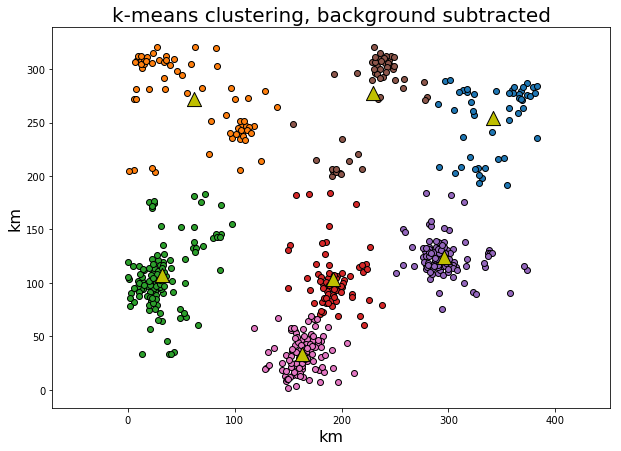

In [27]:
x_grid = np.arange(0., max(long_rect_km), 10.)
y_grid = np.arange(0., max(lat_rect_km), 10.)
coords_rect_over = circle_overdensity(coords_rect, x_grid, y_grid, 25)
clusters_rect_over, centroids_rect_over = k_means(coords_rect_over, 7, 20)

plt.close('all')
plt.figure(figsize=(10,7))
for key in clusters_rect_over.keys():
    plt.scatter([j[0] for j in clusters_rect_over[key]], [j[1] for j in clusters_rect_over[key]], edgecolor='k')
plt.scatter([c[0] for c in centroids_rect_over], [c[1] for c in centroids_rect_over],
            edgecolor='k', facecolor='y', marker='^', s=200)
plt.axis('equal')
plt.title('k-means clustering, background subtracted', size=20)
plt.xlabel('km', size=16)
plt.ylabel('km', size=16)

plt.show()

Somewhat better. Most empty areas are excluded from the clusters now! Let's examine the applicability of what we've done, by comparing the clustering of Utah and Iowa.

# k-means comparison: Utah vs Iowa

We again have to get the vertices of each state to get the data we're interested in. Then let's apply our k-means algorithm and see how these (very different) states compare!

Clustering with converged in 8 iterations!
Clustering with converged in 5 iterations!


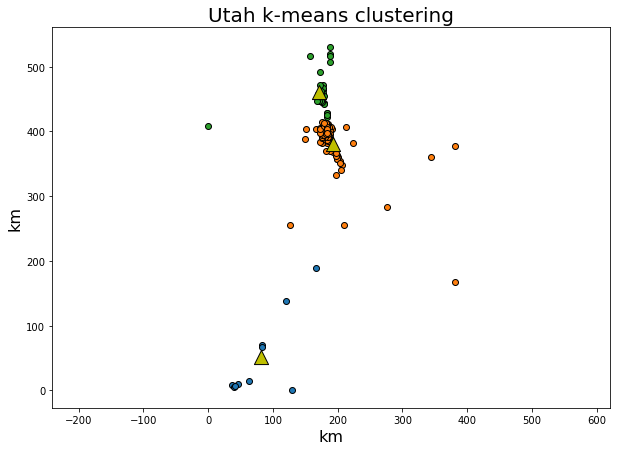

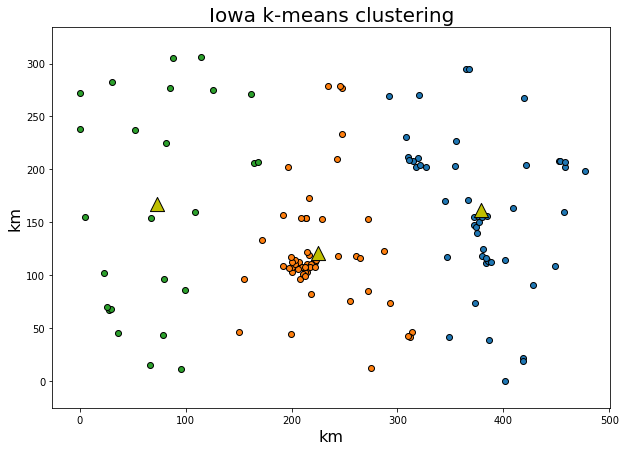

In [28]:
vertices_ut = [(-114.1, 37.0),
               (-114.1, 42.0),
               (-111.1, 42.0),
               (-111.1, 41.0),
               (-109.0, 41.0),
               (-109.0, 37.0)]
vertices_ia = [(-95.7, 40.6),
               (-96.6, 43.5),
               (-91.3, 43.5),
               (-90.9, 42.7),
               (-90.3, 42.4),
               (-91.2, 40.6)]

# Create paths and find data inside thos paths
ll_ut, ut_path = inside_path(coords_full, vertices_ut)
ll_ia, ia_path = inside_path(coords_full, vertices_ia)

long_ut, lat_ut = [[x[i] for x in ll_ut] for i in range(2)]
long_ia, lat_ia = [[x[i] for x in ll_ia] for i in range(2)]

# Conversion of degrees to km from Prime Meridian (longitude) and Equator (latitude)
long_ut = np.asarray(long_ut)
lat_ut = np.asarray(lat_ut)
long_ut_km = 111.320*np.cos(np.median(lat_ut)*np.pi/180.)*long_ut # km west of Prime Meridian
long_ut_km -= min(long_ut_km)
lat_ut_km = 110.574*lat_ut #km north of equator
lat_ut_km -= min(lat_ut_km)

long_ia = np.asarray(long_ia)
lat_ia = np.asarray(lat_ia)
long_ia_km = 111.320*np.cos(np.median(lat_ia)*np.pi/180.)*long_ia # km west of Prime Meridian
long_ia_km -= min(long_ia_km)
lat_ia_km = 110.574*lat_ia #km north of equator
lat_ia_km -= min(lat_ia_km)

coords_ut = [(long_ut_km[i], lat_ut_km[i]) for i in range(len(long_ut_km))]
coords_ia = [(long_ia_km[i], lat_ia_km[i]) for i in range(len(long_ia_km))]

clusters_ut, centroids_ut = k_means(coords_ut, 3, 10)
clusters_ia, centroids_ia = k_means(coords_ia, 3, 10)

plt.figure(figsize=(10,7))
for key in clusters_ut.keys():
    plt.scatter([j[0] for j in clusters_ut[key]], [j[1] for j in clusters_ut[key]], edgecolor='k')
plt.scatter([c[0] for c in centroids_ut], [c[1] for c in centroids_ut],
            edgecolor='k', facecolor='y', marker='^', s=200)
plt.axis('equal')
plt.title('Utah k-means clustering', size=20)
plt.xlabel('km', size=16)
plt.ylabel('km', size=16)

plt.show()

plt.figure(figsize=(10,7))
for key in clusters_ia.keys():
    plt.scatter([j[0] for j in clusters_ia[key]], [j[1] for j in clusters_ia[key]], edgecolor='k')
plt.scatter([c[0] for c in centroids_ia], [c[1] for c in centroids_ia],
            edgecolor='k', facecolor='y', marker='^', s=200)
plt.axis('equal')
plt.title('Iowa k-means clustering', size=20)
plt.xlabel('km', size=16)
plt.ylabel('km', size=16)

plt.show()

Okay, not surprisingly, Utah and Iowa are very different. The former is mostly mountain and desert, save for Salt Lake City, Provo, and St. George. Iowa on the other hand has a very diffuse spread of restaurants, since most of the state is fairly habitable and probably accessible. **In fact, ever since the first visualization of the data (of the entire country) it's been apparent that the distribution of McDonald's restaurants is a good indicator of ACCESSBILITY rather than population**. Let's try that "cleaner" k-means method, where we subtract the "counting-in-circles" overdensity. This should mostly remove the diffuse backgrounds, leaving Utah mostly the same but drastically reducing Iowa down to its more crowded cities.

Clustering with converged in 3 iterations!
Could not converge; stopped at 10 iterations!


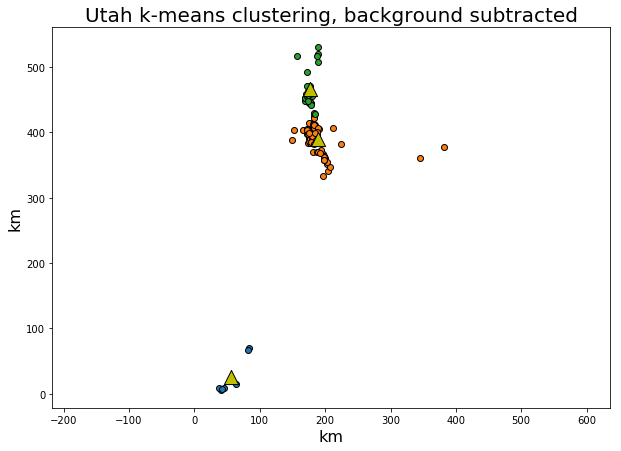

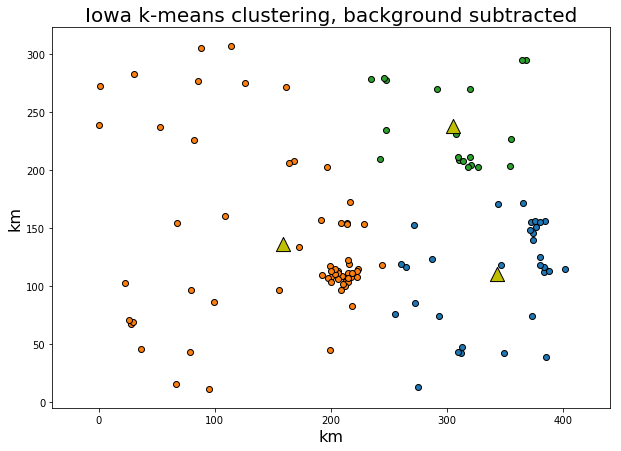

In [29]:
x_grid_ut = np.arange(0., max(long_ut_km), 10.)
y_grid_ut = np.arange(0., max(lat_ut_km), 10.)
coords_ut_over = circle_overdensity(coords_ut, x_grid_ut, y_grid_ut, 25)
x_grid_ia = np.arange(0., max(long_ut_km), 10.)
y_grid_ia = np.arange(0., max(lat_ut_km), 10.)
coords_ia_over = circle_overdensity(coords_ia, x_grid_ia, y_grid_ia, 25)

clusters_ut_over, centroids_ut_over = k_means(coords_ut_over, 3, 10)
clusters_ia_over, centroids_ia_over = k_means(coords_ia_over, 3, 10)

plt.figure(figsize=(10,7))
for key in clusters_ut_over.keys():
    plt.scatter([j[0] for j in clusters_ut_over[key]], [j[1] for j in clusters_ut_over[key]], edgecolor='k')
plt.scatter([c[0] for c in centroids_ut_over], [c[1] for c in centroids_ut_over],
            edgecolor='k', facecolor='y', marker='^', s=200)
plt.axis('equal')
plt.title('Utah k-means clustering, background subtracted', size=20)
plt.xlabel('km', size=16)
plt.ylabel('km', size=16)

plt.show()

plt.figure(figsize=(10,7))
for key in clusters_ia_over.keys():
    plt.scatter([j[0] for j in clusters_ia_over[key]], [j[1] for j in clusters_ia_over[key]], edgecolor='k')
plt.scatter([c[0] for c in centroids_ia_over], [c[1] for c in centroids_ia_over],
            edgecolor='k', facecolor='y', marker='^', s=200)
plt.axis('equal')
plt.title('Iowa k-means clustering, background subtracted', size=20)
plt.xlabel('km', size=16)
plt.ylabel('km', size=16)

plt.show()

It didn't get much better for Iowa. Perhaps we'd have to be smarter with how we get our background.